In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rc, plot
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_recall_curve, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from sklearn import metrics

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)



df = pd.read_csv('https://raw.githubusercontent.com/Yorko/mlcourse.ai/master/data/telecom_churn.csv')

In [8]:
# Сделаем маппинг бинарных колонок 
# и закодируем dummy-кодированием штат (для простоты, лучше не делать так для деревянных моделей)

d = {'Yes' : 1, 'No' : 0}

df['International plan'] = df['International plan'].map(d)
df['Voice mail plan'] = df['Voice mail plan'].map(d)
df['Churn'] = df['Churn'].astype('int64')

le = LabelEncoder()
df['State'] = le.fit_transform(df['State'])

ohe = OneHotEncoder(sparse=False)

encoded_state = ohe.fit_transform(df['State'].values.reshape(-1, 1))
tmp = pd.DataFrame(encoded_state,  
                   columns=['state ' + str(i) for i in range(encoded_state.shape[1])])
df = pd.concat([df, tmp], axis=1)

Confusion matrix, without normalization
[[913  28]
 [118  41]]


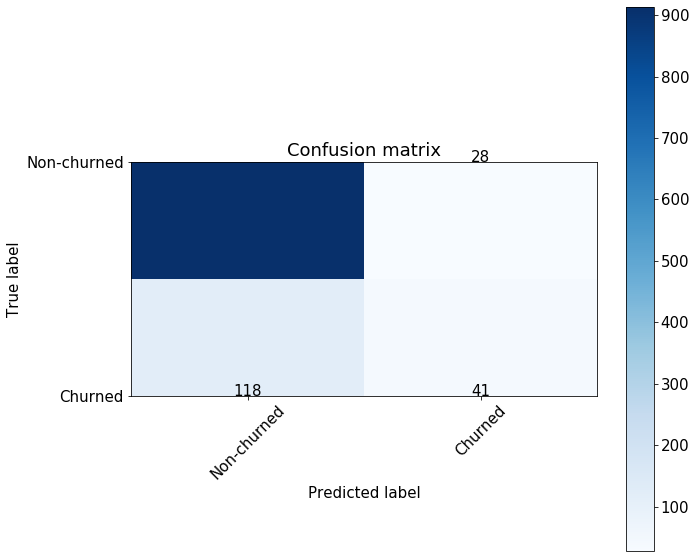

In [9]:
X = df.drop('Churn', axis=1)
y = df['Churn']

# Делим выборку на train и test, все метрики будем оценивать на тестовом датасете

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,  test_size=0.33, random_state=42)

# Обучаем ставшую родной логистическую регрессию

lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)
# Воспользуемся функцией построения матрицы ошибок из документации sklearn

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, lr.predict(X_test))
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-churned', 'Churned'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [10]:
report = classification_report(y_test, lr.predict(X_test), target_names=['Non-churned', 'Churned'])
print(report)

              precision    recall  f1-score   support

 Non-churned       0.89      0.97      0.93       941
     Churned       0.59      0.26      0.36       159

    accuracy                           0.87      1100
   macro avg       0.74      0.61      0.64      1100
weighted avg       0.84      0.87      0.84      1100



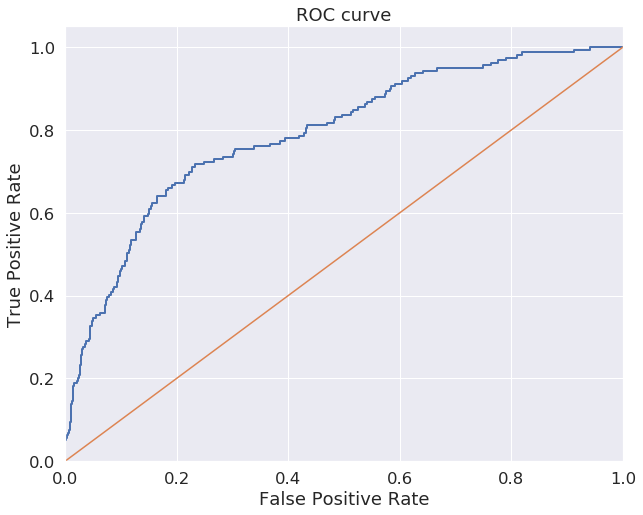

In [14]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds = metrics.roc_curve(y_test, lr.predict_proba(X_test)[:,1], pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show();